<a href="https://colab.research.google.com/github/ishikaa25/LST/blob/master/VAE_NoLightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code file trains an encoder that takes image and makes its latent space embeddings. 

```
Network: Encoder >> Latent Space >> Decoder
```
This network/flow is used to train the VAE's Encoder.



In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocess (CIFAR10)

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                              ])
trainset = datasets.CIFAR10('PATH_TO_STORE_TRAINSET', train=True, transform=transform,download=True)


Extracting PATH_TO_STORE_TRAINSET/cifar-10-python.tar.gz to PATH_TO_STORE_TRAINSET


# VAE part

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [7]:
class EncoderBlock(nn.Module):

  expansion = 1
  def __init__(self,inplanes, planes, stride=1, downsample=None):
    super().__init__()

    self.conv1 = nn.Conv2d(inplanes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.downsample = downsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [8]:
class ResNetEncoder(nn.Module):

  def __init__(self,block,layers,first_conv=False,maxpool1=False):
    super().__init__()

    self.inplanes = 64

    if first_conv:
      self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    else:
      self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)

    self.bn1 = nn.BatchNorm2d(self.inplanes)
    self.relu = nn.ReLU(inplace=True)

    if maxpool1:
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    else:
      self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)
                                  
    self.layer1 = self._make_layer(block,64,layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


  def _make_layer(self, block, planes, blocks, stride=1):

    downsample = None

    if stride != 1 or self.inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes * block.expansion)
        )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)
    

  def forward(self,x):

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)

    return x


In [9]:
# a = resnet18_encoder(False,False)
def resnet18_encoder(first_conv, maxpool1):
    return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)

Decoder

In [10]:
class Interpolate(nn.Module):
  def __init__(self,size=None,scale=None):
    super().__init__()
    self.size, self.scale = size, scale

  def forward(self,x):
    return F.interpolate(x,self.size,self.scale)


def resize_conv(in_planes,out_planes,scale=1,k=3):
  if k==3:
    if scale==1:
      return nn.Conv2d(in_planes,out_planes,kernel_size=3,padding=1,bias=False)
    else:
      return nn.Sequential(Interpolate(scale=scale), nn.Conv2d(in_planes,out_planes,kernel_size=3,padding=1,bias=False))

  else:
    if scale==1:
      return nn.Conv2d(in_planes,out_planes,kernel_size=1,bias=False)
    else:
      return nn.Sequential(Interpolate(scale=scale), nn.Conv2d(in_planes,out_planes,kernel_size=1,bias=False))


In [11]:
#Test 
#x = np.random.rand(1,3,2,2)
# g = F.interpolate(torch.from_numpy(x),[3,3])

In [12]:
class DecoderBlock(nn.Module):


    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        self.conv1 = resize_conv(inplanes, inplanes,k=3)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv(inplanes, planes, scale,k=3)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out


In [39]:
class ResNetDecoder(nn.Module):
    """
    Resnet in reverse order
    """

    def __init__(self, block, layers, latent_dim, input_height, first_conv=False, maxpool1=False):
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.first_conv = first_conv
        self.maxpool1 = maxpool1
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)

        if self.maxpool1:
            self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
            self.upscale_factor *= 2
        else:
            self.layer4 = self._make_layer(block, 64, layers[3])

        if self.first_conv:
            self.upscale = Interpolate(scale=2)
            self.upscale_factor *= 2
        else:
            self.upscale = Interpolate(scale=1)

        # interpolate after linear layer using scale factor
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(64 * block.expansion, 3, kernel_size=3, stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv(self.inplanes, planes * block.expansion, scale, k=1),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)

        x = self.conv1(x)
        return x


In [14]:
def resnet18_decoder(latent_dim, input_height, first_conv, maxpool1):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)

In [16]:
class VAE(nn.Module):

    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super(VAE,self).__init__()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                            shuffle=True, num_workers=2)

print(len(trainset))

50000


In [41]:
vae = VAE()

In [19]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

In [43]:
epochs = 5

for epoch in range(epochs):
  i=0
  
  for batch in trainloader:
        i+=1
        x, _ = batch
        # encode x to get the mu and variance parameters
        x_encoded = vae.encoder(x)
        mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = vae.gaussian_likelihood(x_hat, vae.log_scale, x)

        # kl
        kl = vae.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        print("Mini-batch: {}, ELBO Loss: {}".format(i,elbo))
        elbo.backward()
        optimizer.step()
        optimizer.zero_grad()
  

Mini-batch: 1, ELBO Loss: 5098.12353515625
Mini-batch: 2, ELBO Loss: 5116.05322265625
Mini-batch: 3, ELBO Loss: 5108.46142578125
Mini-batch: 4, ELBO Loss: 5140.107421875
Mini-batch: 5, ELBO Loss: 5072.93896484375
Mini-batch: 6, ELBO Loss: 5077.05224609375


KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


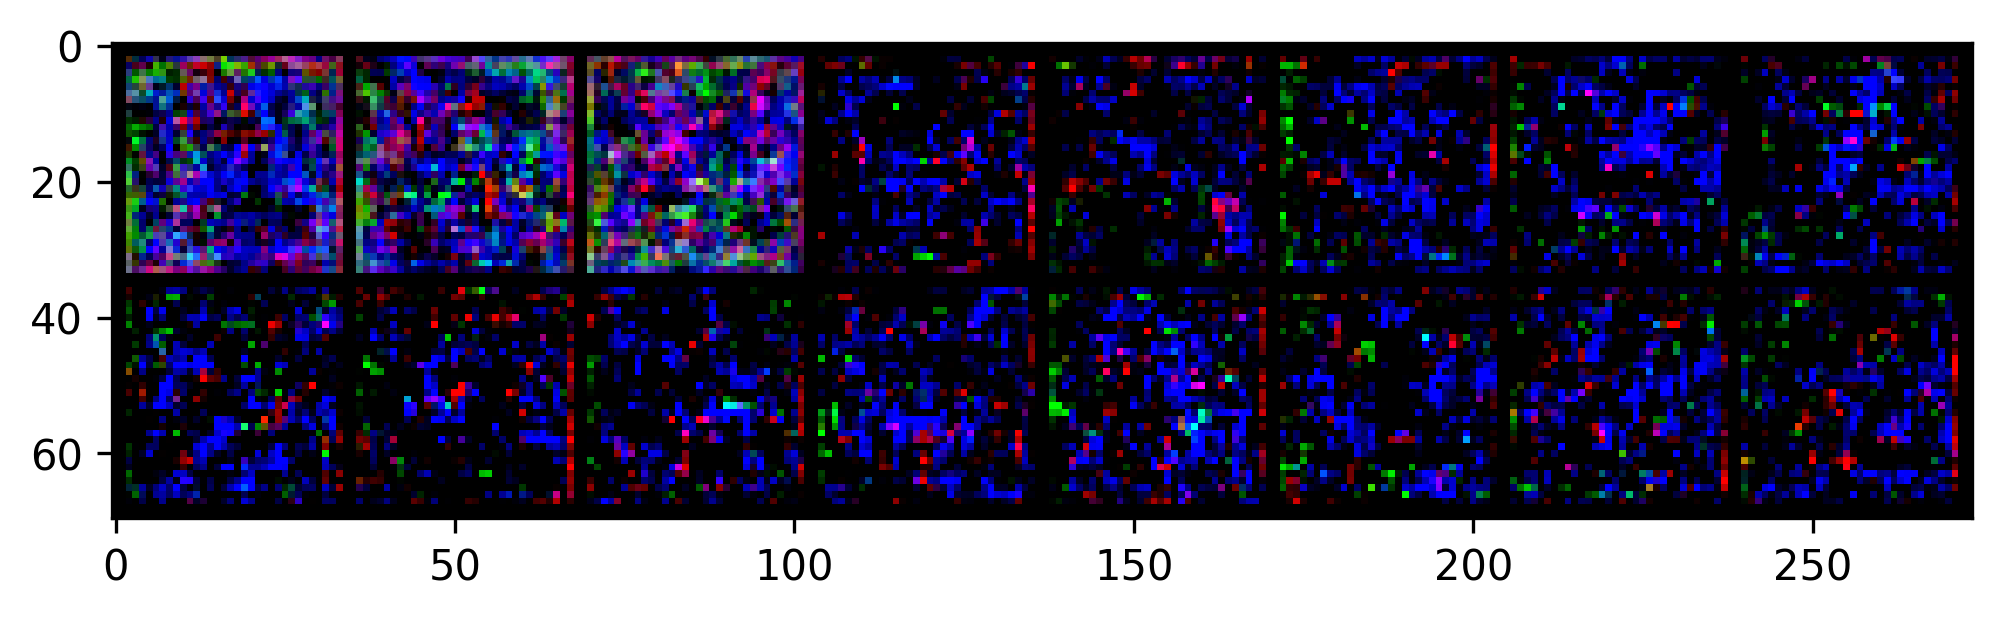

In [45]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
figure(figsize=(8, 3), dpi=300)

x = torch.rand(1, 3, 32, 32)
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
std = torch.exp(log_var / 2)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
  pred = vae.decoder(z)

# Undo normalization
unnorm = UnNormalize((0.5,0.5,0.5), (0.5,0.5,0.5))
img  = make_grid(unnorm(pred)).permute(1,2,0).numpy()

# PLOT IMAGES
imshow(img);